In [ ]:
# !pip install tslearn 

In [8]:
import sys
sys.path.append(
    "../"
)

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import time
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from src.detect_peaks import detect_peaks
from src.utils import *

from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [9]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',\
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}   

INPUT_FOLDER_TRAIN = '../data/raw/UCI_HAR/train/InertialSignals/'
INPUT_FOLDER_TEST = '../data/raw/UCI_HAR/test/InertialSignals/'

LABELFILE_TRAIN = '../data/raw/UCI_HAR/train/y_train.txt'
LABELFILE_TEST = '../data/raw/UCI_HAR/test/y_test.txt'

train_signals, test_signals, train_labels, test_labels = read_data(
    input_folder_train=INPUT_FOLDER_TRAIN,
    input_folder_test=INPUT_FOLDER_TEST,
    labelfile_train=LABELFILE_TRAIN,
    labelfile_test=LABELFILE_TEST
)

train_signals, train_labels = randomize(train_signals, np.array(train_labels))
test_signals, test_labels = randomize(test_signals, np.array(test_labels))

# Baseline clustering

In [10]:
X_train_flattened = train_signals.swapaxes(2, 1).reshape(train_signals.shape[0], -1)
X_test_flattened = test_signals.swapaxes(2, 1).reshape(test_signals.shape[0], -1)

Y_train = np.array(train_labels)
Y_test = np.array(test_labels)

In [11]:
X_train_flattened.shape

(7352, 1152)

In [12]:
scaler = StandardScaler()
X_train_flattened_scaled = scaler.fit_transform(X_train_flattened)
X_test_flattened = scaler.transform(X_test_flattened)

## KMeans

In [13]:
def plot_distortions(k_range, data):
    distortions = []
    K = k_range
    for k in tqdm(K):
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(data)
        distortions.append(kmeanModel.inertia_)

    plt.figure(figsize=(12,6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')
    plt.show()

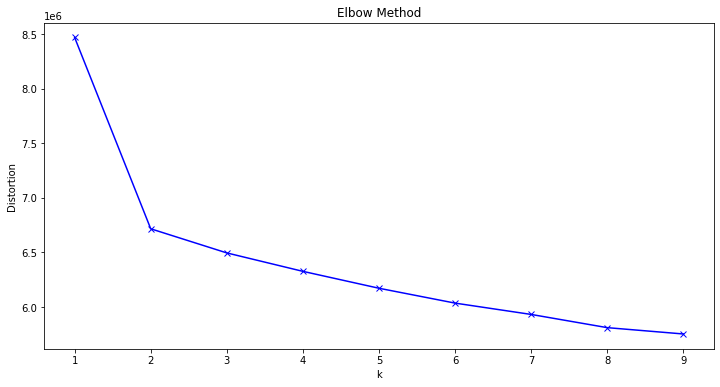

In [14]:
plot_distortions(range(1,10), X_train_flattened_scaled)
# Disctortion - определяется как" сумма квадратов разностей между наблюдениями и соответствующим центроидом

In [15]:
kmeanModel = KMeans(n_clusters=6)
kmeanModel.fit(X_train_flattened_scaled)
clusters = kmeanModel.predict(X_train_flattened_scaled)

## Visualizing clusters

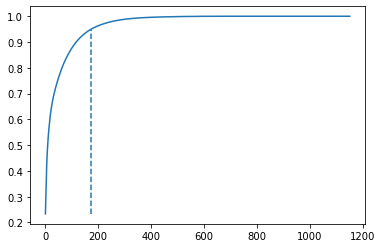

In [16]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train_flattened_scaled)

explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(explained_variance)
components_threshold = np.argwhere(explained_variance > 0.95).reshape(-1)[0]
plt.vlines(components_threshold, explained_variance.min(), 0.95, linestyle='dashed')
plt.show()

In [17]:
pca = PCA(n_components=components_threshold)
pca_transformed = pca.fit_transform(X_train_flattened_scaled)

In [18]:
np.sum(pca.explained_variance_ratio_[:2])

0.27547723677595454

## First 2 PCA components

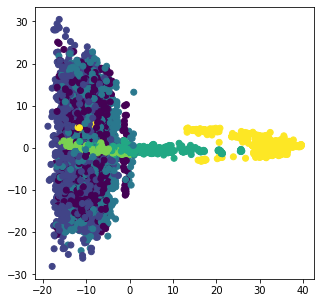

In [12]:
plt.figure(figsize=(5, 5))
plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], c=Y_train)

## TSNE

In [13]:
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_jobs=6)
tsne_transformed = tsne.fit_transform(pca_transformed)

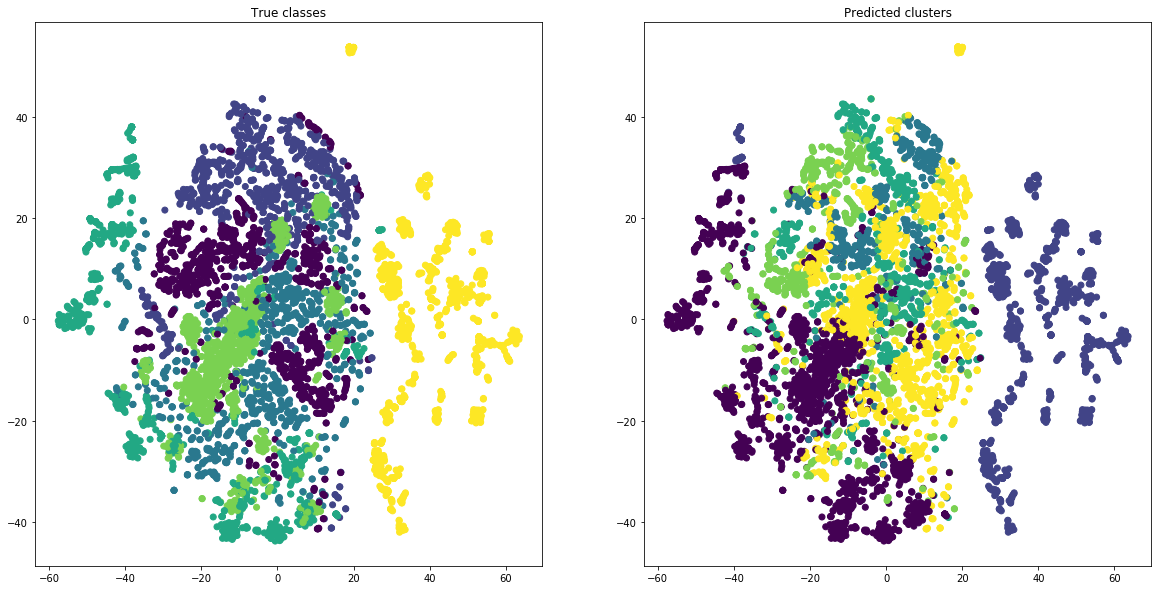

In [14]:
def plot_results(true, predicted, representation):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].scatter(representation[:, 0], representation[:, 1], c=true)
    ax[0].set_title("True classes")
    ax[1].scatter(representation[:, 0], representation[:, 1], c=predicted)
    ax[1].set_title("Predicted clusters")
    plt.show()
    
    
plot_results(Y_train, clusters, tsne_transformed)

Видим, что выше K-mean задался не идеально.

In [19]:
ts_kmeans_euclidian = TimeSeriesKMeans(n_clusters=6, metric="euclidean")
ts_kmeans_euclidian.fit(train_signals)

TimeSeriesKMeans(n_clusters=6)

In [20]:
ts_kmeans_euclidian.cluster_centers_.shape

(6, 128, 9)

Посмотрим на средние значения кластеров. Для простоты будем смотреть только на показания акселерометра

In [21]:
def plot_average_clusters(clusters, data=X_train_flattened):
    labels = ['x', 'y', 'z']
    colors = ['r', 'g', 'b']
    fig, ax = plt.subplots(2, 3, figsize=(15, 7))
    ax = ax.reshape(-1)

    for cluster in range(6):
        for axis in range(3): # усредним все длинны внутри одного класстера
            averages = pd.DataFrame(data).groupby(clusters).mean().iloc[:, 128*axis:128*(axis+1)] 
            ax[cluster].plot(averages.iloc[cluster].values, color=colors[axis], label=labels[axis])
            ax[cluster].set_title(f"Cluster {cluster}, {sum(clusters==cluster)} observations")
            ax[cluster].legend(loc=1)
        ax[cluster].set_ylabel("Amplitude")
        ax[cluster].set_xlabel("observation")

    plt.tight_layout()
    plt.show()
    
def plot_true_averages(Y_train, data=X_train_flattened, activities_description=activities_description):
    labels = ['x', 'y', 'z']
    colors = ['r', 'g', 'b']
    fig, ax = plt.subplots(2, 3, figsize=(15, 7))
    ax = ax.reshape(-1)    
    for activity in range(6):
        for axis in range(3):
            averages = pd.DataFrame(data).groupby(Y_train).mean().iloc[:, 128*axis:128*(axis+1)]
            ax[activity].plot(averages.iloc[activity].values, color=colors[axis], label=labels[axis])
            ax[activity].set_title(f"{activities_description[activity+1]}, {sum(Y_train==activity+1)} observations")
            ax[activity].legend(loc=1)
        ax[activity].set_ylabel("Amplitude")
        ax[activity].set_xlabel("observation")

    plt.tight_layout()
    plt.show()

# Kmeans VS TimeSeriesKmeans

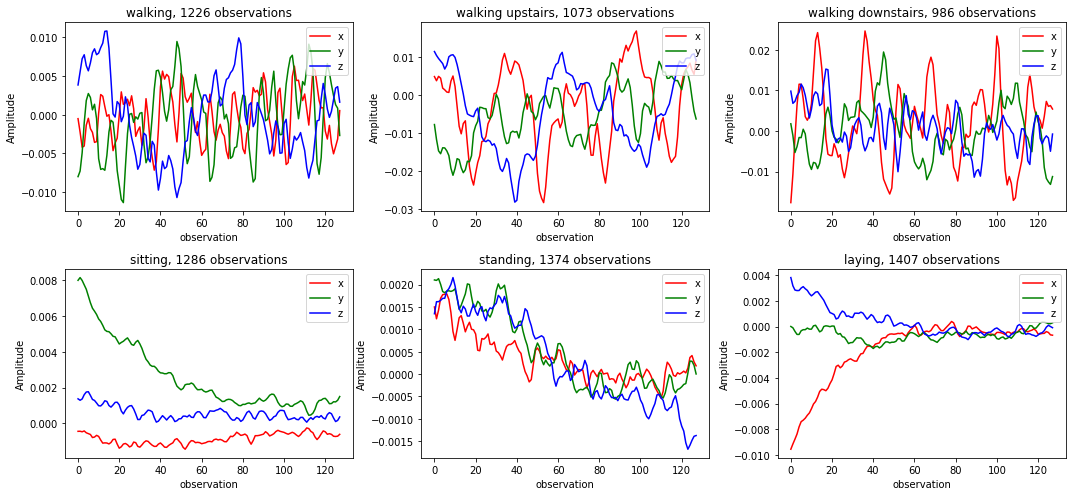

In [18]:
plot_true_averages(Y_train)

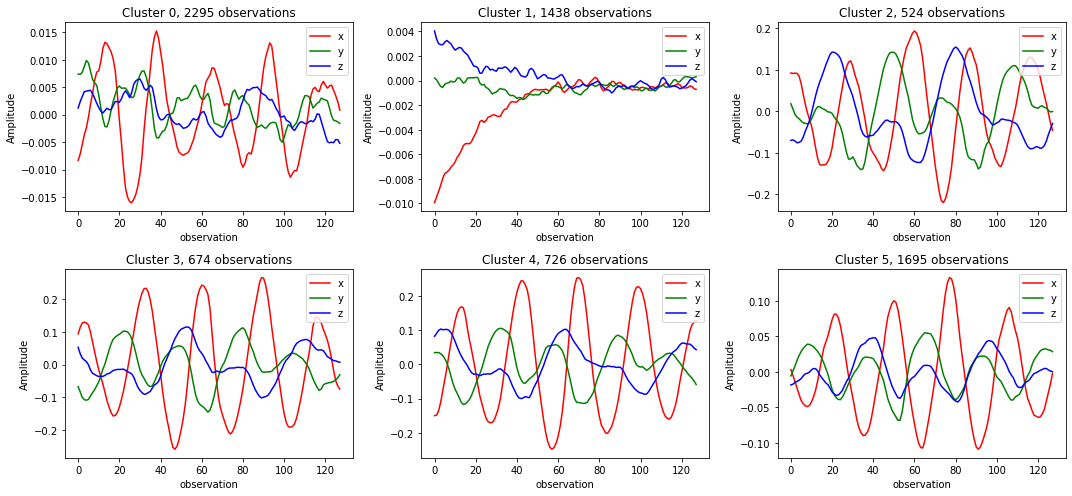

In [19]:
plot_average_clusters(clusters) 

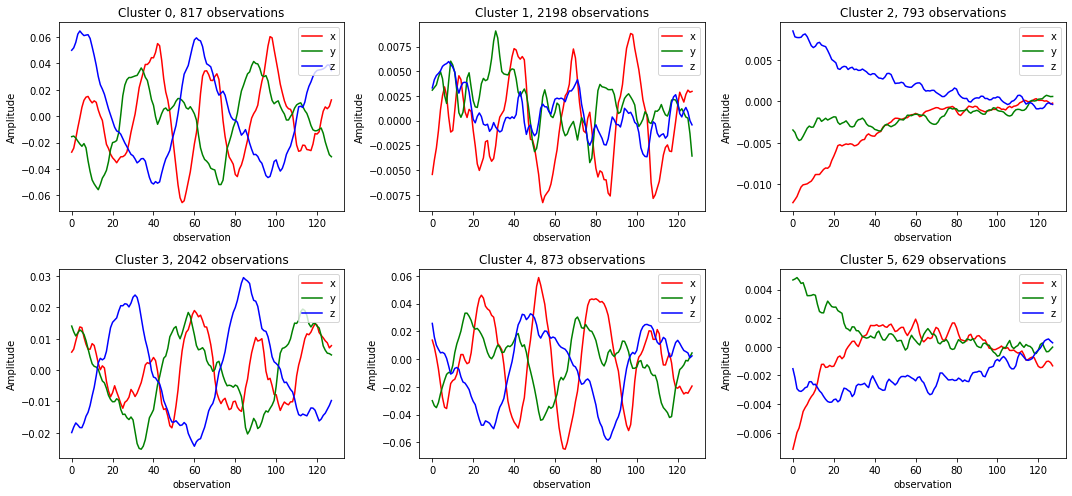

In [20]:
plot_average_clusters(ts_kmeans_euclidian.predict(train_signals))

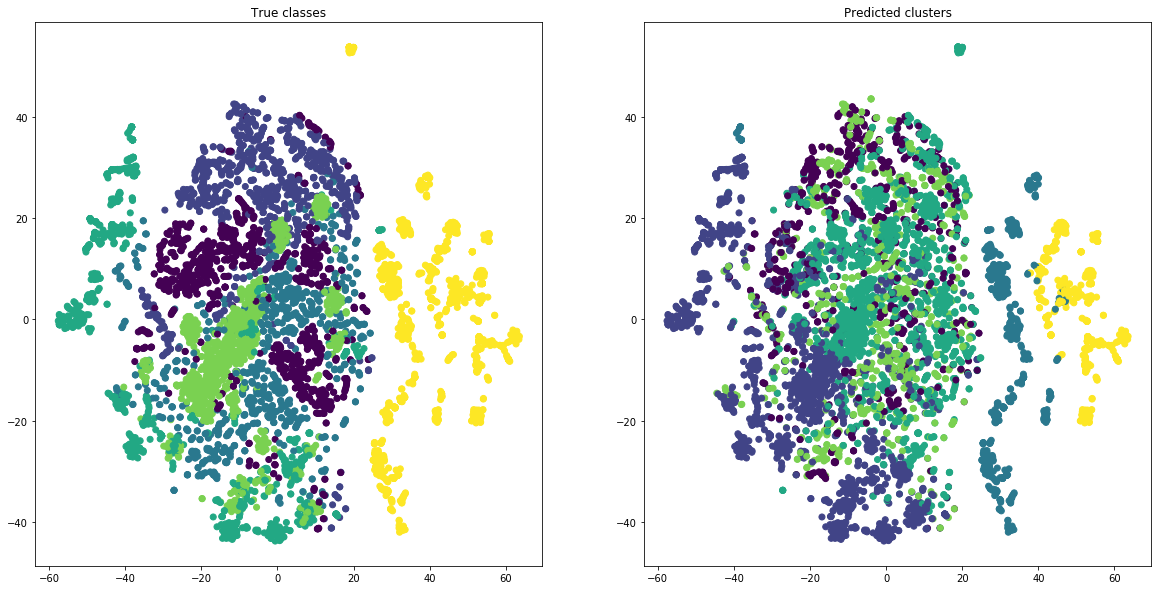

In [21]:
plot_results(Y_train, ts_kmeans_euclidian.predict(train_signals), tsne_transformed)

Выше видим, что K-mean **tslearn** справился лучше

# DTW clustering

In [ ]:
ts_kmeans = TimeSeriesKMeans(n_clusters=6, metric="softdtw", n_jobs=6, max_iter=10)
ts_kmeans.fit(train_signals)

In [ ]:
# import pickle

# with open("../src/ts_kmeans_dtw.pickle", 'wb') as f:
#     pickle.dump(ts_kmeans, f)

In [22]:
import pickle

with open("../src/ts_kmeans_dtw.pickle", 'rb') as f:
    ts_kmeans = pickle.load(f)

In [23]:
ts_kmeans.cluster_centers_.shape

(6, 128, 9)

In [24]:
dtw_clusters = ts_kmeans.predict(train_signals)

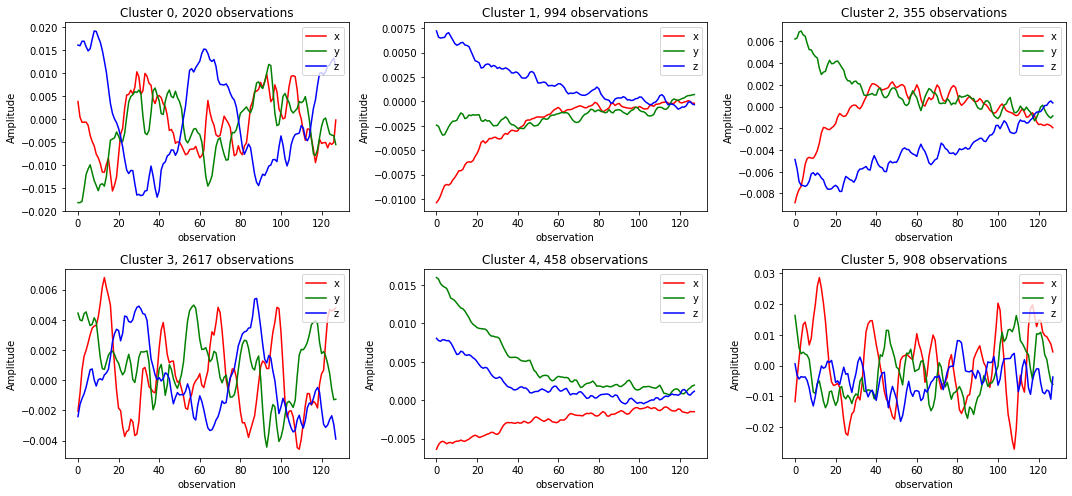

In [25]:
plot_average_clusters(dtw_clusters)

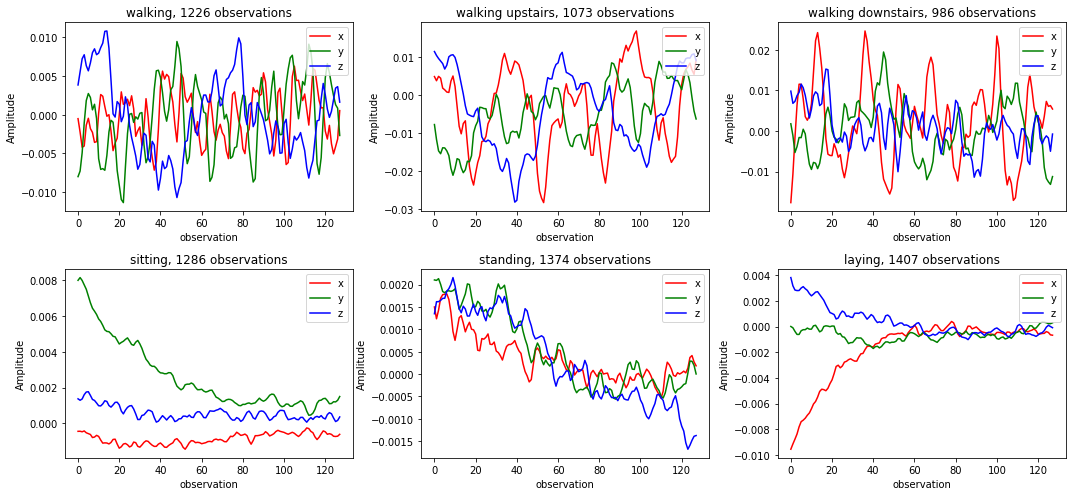

In [26]:
plot_true_averages(Y_train)

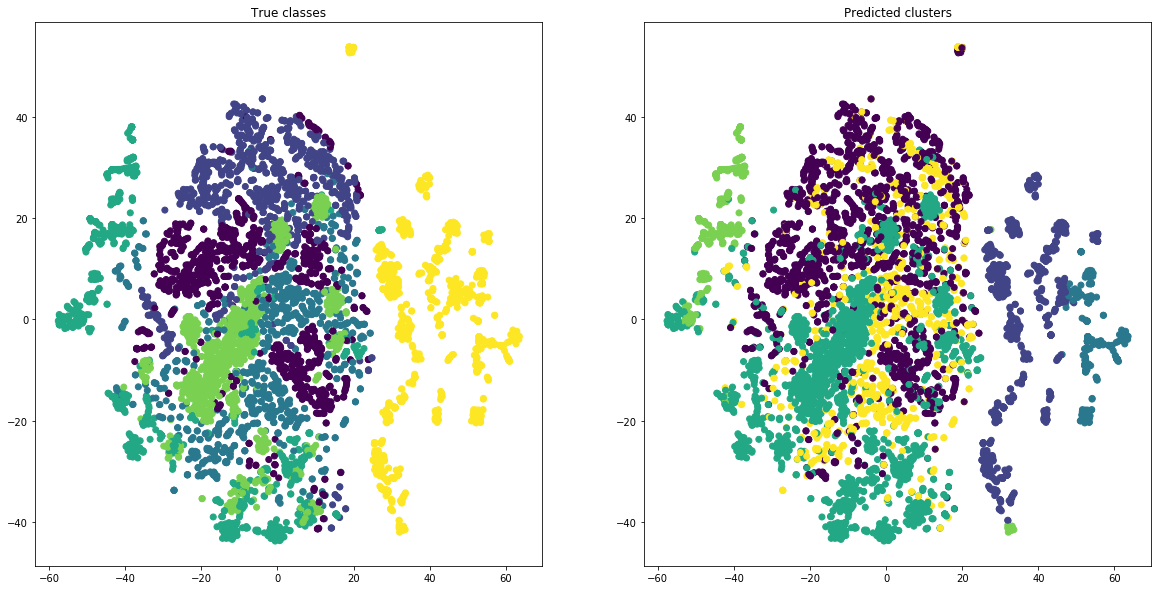

In [27]:
plot_results(Y_train, dtw_clusters, tsne_transformed)

WDT справился еще лучше. Хотя и разбил правый кластер на два.

# Feature clustering

In [25]:
import tsfel
fs = 100
cfg_file = tsfel.get_features_by_domain('temporal')

EXTRACT = True

if EXTRACT:
    X_train = tsfel.time_series_features_extractor(cfg_file, train_signals, fs=fs)
    X_train.to_csv('../data/processed/X_train_tsfel.csv')
else:
    X_train = pd.read_csv('../data/processed/X_train_tsfel.csv', index_col=0)

*** Feature extraction started ***



*** Feature extraction finished ***


In [26]:
from sklearn.feature_selection import VarianceThreshold
# Highly correlated features are removed
corr_features = tsfel.correlated_features(X_train)
X_train.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
X_train = selector.fit_transform(X_train)

Y_train = np.array(train_labels)

In [27]:
X_train_scaled = scaler.fit_transform(X_train)

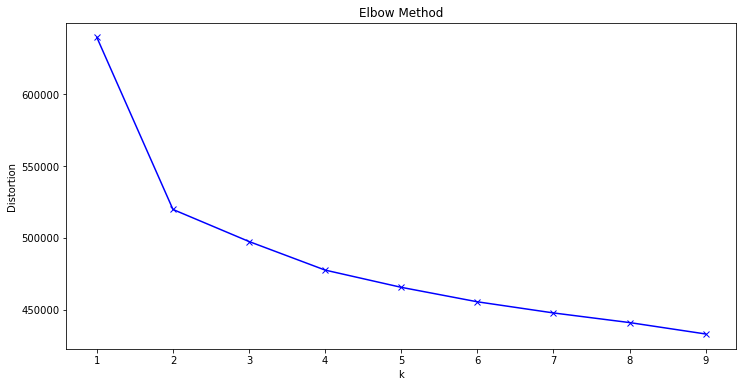

In [28]:
plot_distortions(range(1, 10), X_train_scaled)

In [32]:
kmeanModel_tsfel = KMeans(n_clusters=6)
kmeanModel_tsfel.fit(X_train_scaled)

KMeans(n_clusters=6)

In [33]:
clusters_tsfel = kmeanModel_tsfel.predict(X_train_scaled)

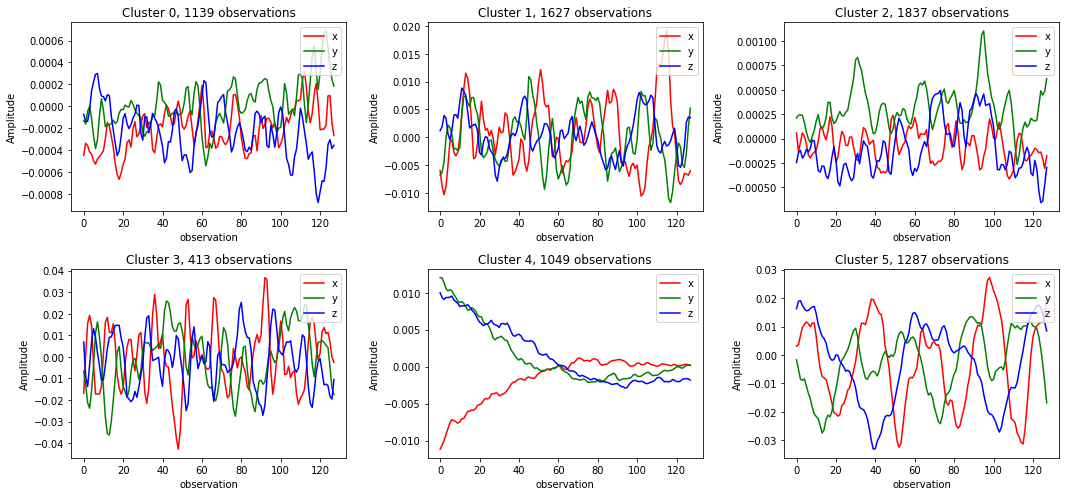

In [34]:
plot_average_clusters(clusters_tsfel)

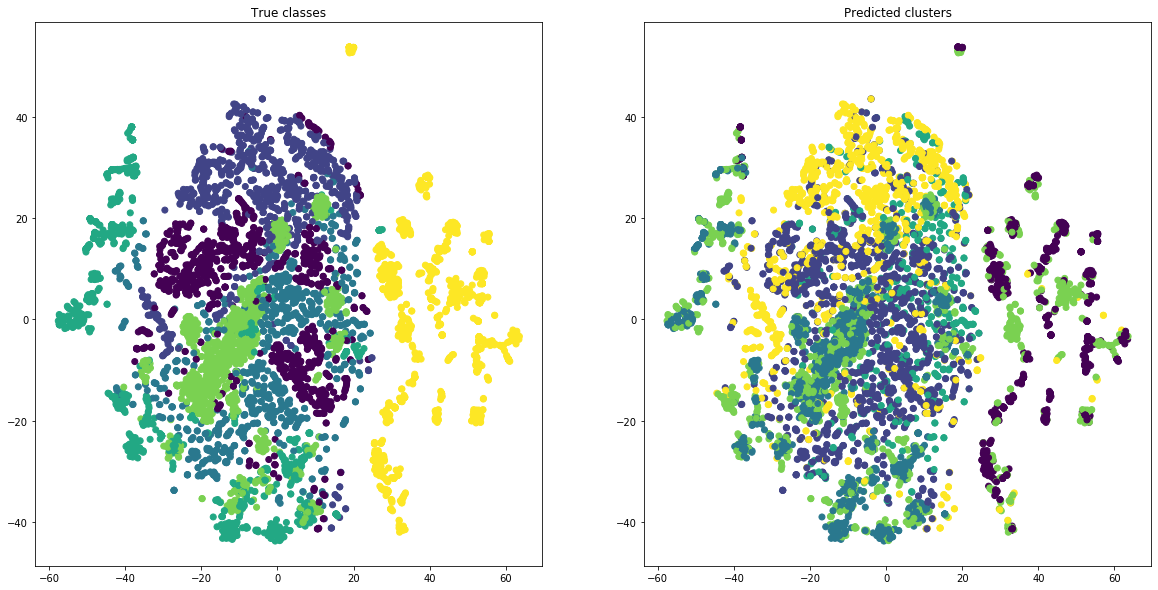

In [35]:
plot_results(Y_train, clusters_tsfel, tsne_transformed)